# Dataset exploration

In this notebook, we will explore and analyse the four PSS datasets that are used in this research, namely A.I. Lab Splitter, Tobacco800 , and the LONG and SHORT datasets from the OpenPSS benchmark. We will explore several general statistics about the datasets, as well as some more advanced features of the datasets such as token distributions and image properties.

## Index

1. [General Statistics](#ref1)
    - 1.1 [Basic Statistics Table](#ref2)
    - 1.2 [KDE Plots](#ref3)
2. [Image Statistics](#ref9)
    - 3.1 [T-sne with pretrained image embeddings](#ref10)
    - 3.2 [Quantifying cluster differences](#ref11) 


Before we start the exploration, we load in the required modules and the datasets in csv format, as well as make a function to load in the images.

In [17]:
import os
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Local imports
%run metricutils.py

First we load in the datasets from the dataframes saved in the datasets directory.

In [18]:
csv_dataframe_root_path = "../resources/datasets"

LONG_train = pd.read_csv(os.path.join(csv_dataframe_root_path, 'LONG', 'dataframes', 'train.csv'))
LONG_test = pd.read_csv(os.path.join(csv_dataframe_root_path, 'LONG', 'dataframes', 'test.csv'))
LONG_df = pd.concat([LONG_train, LONG_test], axis=0).fillna(' ')

SHORT_train =  pd.read_csv(os.path.join(csv_dataframe_root_path, 'SHORT', 'dataframes', 'train.csv'))
SHORT_test = pd.read_csv(os.path.join(csv_dataframe_root_path, 'SHORT', 'dataframes','test.csv'))
SHORT_df = pd.concat([SHORT_train, SHORT_test], axis=0).fillna(' ')

TOBACCO_train = pd.read_csv(os.path.join(csv_dataframe_root_path, 'TOBACCO800', 'dataframes','train.csv'))
TOBACCO_test = pd.read_csv(os.path.join(csv_dataframe_root_path, 'TOBACCO800', 'dataframes','test.csv'))
TOBACCO_df = pd.concat([TOBACCO_train, TOBACCO_test], axis=0).fillna(' ')

AILAB_train = pd.read_csv(os.path.join(csv_dataframe_root_path, 'AILAB', 'dataframes','train.csv'))
AILAB_test = pd.read_csv(os.path.join(csv_dataframe_root_path, 'AILAB', 'dataframes','test.csv'))
AILAB_df = pd.concat([AILAB_train, AILAB_test], axis=0).fillna(' ')


<a id="ref1" />

## General Statistics

For the first part of the comparison of the different datasets, we will just report some basic statistics such as the number of streams and the number of pages and documents, etc. We will also go into a bit more detail by showing some distribution plots of the sizes of the documents and streams (where applicable).

In [19]:
def get_general_statistics(dataframe) -> pd.DataFrame:
    number_of_streams = dataframe.name.nunique()
    number_of_documents = dataframe.label.sum() # number of documents is number of ones in label column in binary format.
    number_of_pages = dataframe.shape[0]
    
    # Get the percentage of singleton documents in the daseset.
    ground_truth_dict = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_ground_truth_dict = {key: bin_to_length_list(val) for key, val in ground_truth_dict.items()}
    all_document_lengths = pd.Series(item for val in length_list_ground_truth_dict.values() for item in val)
    percentage_singletons = (all_document_lengths == 1).mean()
    num_documents_in_streams = pd.Series([len(value) for value in length_list_ground_truth_dict.values()])
    num_pages_in_streams = pd.Series([sum(value) for value in length_list_ground_truth_dict.values()])
    
    # finally, we will set the dtypes of the columns to the appropriate type
    
    return pd.Series({'Number of Streams':number_of_streams,
                      'Number of Documents': number_of_documents,
                      "Number of Pages": number_of_pages,
                      "Percentage of Singletons": round(percentage_singletons, 2),
                     'Median Number of Pages in Stream': num_pages_in_streams.median(),
                     'Median Number of Documents in Stream': num_documents_in_streams.median()})

<a id="ref2" />

### Table with general statistics

First we wil create a simple table with some of the general statistics of all of the datasets.

In [20]:
# Generate the general statistics for all datasets and put them into one pandas dataframe

LONG_statistics = get_general_statistics(LONG_df)
SHORT_statistics = get_general_statistics(SHORT_df)
TOBACCO_statistics = get_general_statistics(TOBACCO_df)
AILAB_statistics = get_general_statistics(AILAB_df)

all_datasets_general_statistics = pd.DataFrame({'Tobacco800': TOBACCO_statistics,
                                                'AI LAB Splitter': AILAB_statistics,
                                                'C1': LONG_statistics,
                                                'C2': SHORT_statistics}).T.astype({'Number of Streams': 'int',
                                                                             'Number of Documents': 'int',
                                                                             'Number of Pages': 'int',
                                                                               'Median Number of Pages in Stream': 'int',
                                                                               'Median Number of Documents in Stream': 'int'})

all_datasets_general_statistics

,Number of Streams,Number of Documents,Number of Pages,Percentage of Singletons,Median Number of Pages in Stream,Median Number of Documents in Stream
Tobacco800,1,736,1290,0.63,1290,736
AI LAB Splitter,1869,5487,31789,0.46,9,1
C1,110,24181,89491,0.30,217,55
C2,223,7112,44969,0.32,89,11


Please note here that tobacco does actually not have the concept of streams, so the number of streams and average number of pages in stream numbers are not really meaningful. The above numbers already show some interesting things, mostly about the percentage of singletons and the average number of pages in a stream. We see that the percentage of singletons for for C1 and C2 is very similar, and that for AI lab splitter it is a bit higher, and quite a bit higher for Tobacco. The most interesting observation however, is the large difference in the average number of pages in a stream, with the C1 dataset having by far the largest number (tobacco800 excluded as it is just one stream). Also, we see that the AI LAB splitter contains streams that are quite short, with only 17 pages in a stream.

<a id="ref3" />

### Kernel Denstiy Estimation Plots

Apart from just a table with the raw statistics of the datasets, we will also plot some distributions, namely of the number of clusters in a stream, and the number of pages in a document, which will give as some more interesting and visual insights into the differences between the datasets.

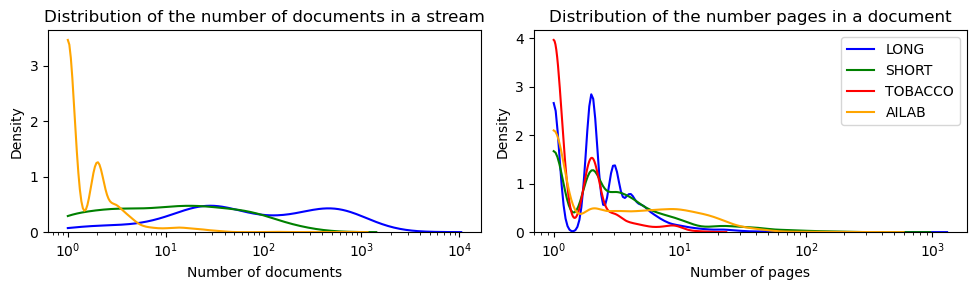

In [21]:
color_map = {'LONG': 'blue', 'SHORT': 'green', 'TOBACCO': 'red', 'AILAB': 'orange'}
fig, ax = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 3))
for i, (name, dataframe) in enumerate({'LONG': LONG_df, 'SHORT': SHORT_df, 'TOBACCO': TOBACCO_df, 'AILAB': AILAB_df}.items()):
    page_labels = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_streams = {key: bin_to_length_list(val) for key, val in page_labels.items()}
    stream_lengths = [len(item) for item in length_list_streams.values() if len(item)]
    document_lengths = [pages for document in length_list_streams.values() for pages in document]
    if name != 'TOBACCO':
        sns.kdeplot(data=stream_lengths, ax=ax[0], log_scale=True, label=name, color=color_map[name], clip=[0, 1228])
    sns.kdeplot(data=document_lengths, ax=ax[1], log_scale=True, label=name, color=color_map[name], clip=[0, 962])

ax[0].set_title("Distribution of the number of documents in a stream")
ax[0].set_xlabel("Number of documents")
ax[1].set_title("Distribution of the number pages in a document")
ax[1].set_xlabel("Number of pages")
plt.legend()
plt.tight_layout()
plt.show()

    

Studying the above plots, we can see some interesting differences,as the large difference between the distribution of the number of documents in a stream between the LONG, SHORT corpora and the AILAB dataset. We also see fairly similar distribution for all datasets regarding the number of pages in a document, where there is a large number of documents that has only a single page, and the percentage of documents that has more than $n$ pages quickly drops after this.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


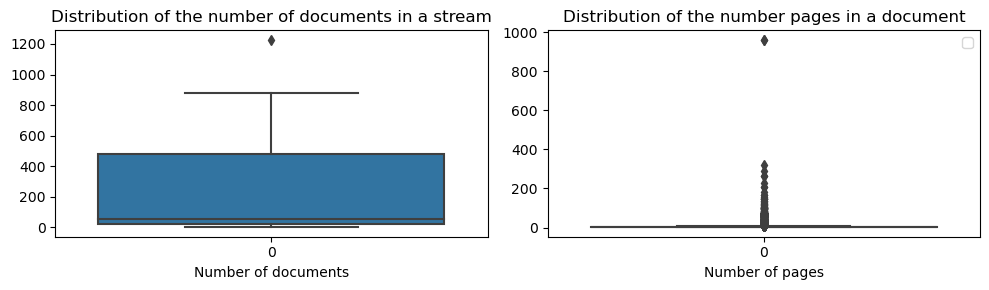

In [22]:
# TODO: make multiple nice boxplots to show this.
color_map = {'LONG': 'blue', 'SHORT': 'green', 'TOBACCO': 'red', 'AILAB': 'orange'}
fig, ax = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 3))
for i, (name, dataframe) in enumerate({'LONG': LONG_df, 'SHORT': SHORT_df, 'TOBACCO': TOBACCO_df, 'AILAB': AILAB_df}.items()):
    page_labels = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_streams = {key: bin_to_length_list(val) for key, val in page_labels.items()}
    stream_lengths = [len(item) for item in length_list_streams.values() if len(item)]
    document_lengths = [pages for document in length_list_streams.values() for pages in document]
    if name != 'TOBACCO':
        sns.boxplot(data=stream_lengths, ax=ax[0])
    sns.boxplot(data=document_lengths, ax=ax[1])
    break
    
ax[0].set_title("Distribution of the number of documents in a stream")
ax[0].set_xlabel("Number of documents")
ax[1].set_title("Distribution of the number pages in a document")
ax[1].set_xlabel("Number of pages")
plt.legend()
plt.tight_layout()
plt.show()

    

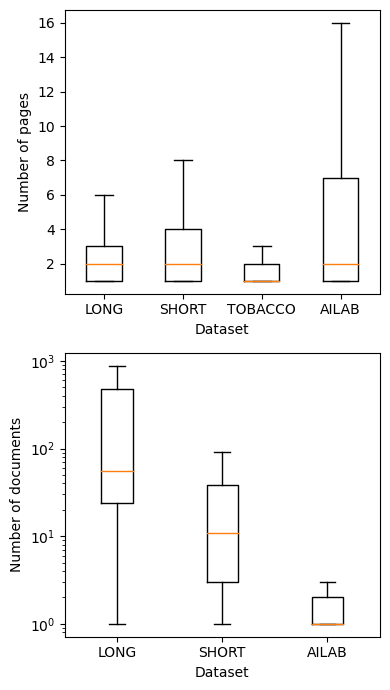

In [23]:
# TODO: make multiple nice boxplots to show this.
document_lengths_dict = {}
stream_lengths_dict = {}
for i, (name, dataframe) in enumerate({'LONG': LONG_df, 'SHORT': SHORT_df, 'TOBACCO': TOBACCO_df, 'AILAB': AILAB_df}.items()):
    page_labels = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_streams = {key: bin_to_length_list(val) for key, val in page_labels.items()}
    stream_lengths = [len(item) for item in length_list_streams.values() if len(item)]
    document_lengths = [pages for document in length_list_streams.values() for pages in document]
    document_lengths_dict[name] = document_lengths
    if name != 'TOBACCO':
        stream_lengths_dict[name] = stream_lengths

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4, 7))
# document length boxplots
ax[0].boxplot(document_lengths_dict.values(), sym='')
ax[0].set_xticklabels(document_lengths_dict.keys())

# Stream length boxplots
ax[1].boxplot(stream_lengths_dict.values(), sym='')

ax[1].set_xticklabels(stream_lengths_dict.keys())
ax[0].set_xlabel("Dataset")
ax[1].set_xlabel("Dataset")

ax[0].set_ylabel("Number of pages")
ax[1].set_ylabel("Number of documents")

#set y-axis to logscale
ax[1].set_yscale('log')

# For the first plot set the y ticks labels
from matplotlib.ticker import MaxNLocator
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('images/boxplots_distributions.eps',bbox_inches='tight', format='eps')
plt.show()

<a id="ref4" />

<a id="ref8" />

<a id="ref9" />

## Image distributions

To get some insight into the images present in the four different datasets, we will use T-SNE plots to get distribution to show the representations of the pages for all of the datasets. We will also experiment with differentiating between the positive and negative classes in the images to see if this offers any more insights.  We will not only focus on the diferences between the LONG and SHORT datasets and the other datasets, but we will also look into the differences between LONG and SHORT, as they come from similar organizations, so the image distributions might also be very similar.

**NOTE** Because the actual calculation of the T-SNE vectors takes quite a long time for the larger datasets, we will first show the comparison be using a random sample from all of the datasets.

In [24]:
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
from numpy import asarray
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

First, we will need to write some boilerplate code that loads the images from the paths and converts them to the appropriate format.

In [25]:
def perform_tsne(image_dictionary: dict, components: int=2):    
    # We fit on everything and then we transform for all sets seperately.
    tsne = TSNE(n_components=components, init='pca', learning_rate='auto')
    
    # We fit on everything and then we transform for all sets seperately.
    fit_vectors = np.vstack([item for item in image_dictionary.values()])
    return np.hstack([tsne.fit_transform(fit_vectors[:, :-1]), fit_vectors[:, -1].reshape(-1, 1)])

In [26]:
def prepare_images_for_visualization(image_dict: dict):
    # this will append a column to each dataset with an integer label, specifying to which dataset the 
    # vector belongs
    output_dict = {}
    translate_dict = {}
    
    for i, (key, value) in enumerate(image_dict.items()):
        output_dict[key] = np.hstack([value, np.repeat(i, repeats=len(value)).reshape(-1, 1)])
        translate_dict[i] = key
    return output_dict, translate_dict

<a id="ref10" />

## T-SNE with ResNet pretrained model vectors 

Following other works, we use a pretrained model for Image Classification, Resnet in our case, to retrieve embeddings for all the images, which we then use to perform the T-SNE calculations. Because for the large datasets it is quite time-consuming, we provide these vectors with the notebook, as we have run the feature extraction process seperately on our compute cluster. (the extraction script is also shared) 

In [26]:
tobacco_features = np.load('../../raw_images/TOBACCO800/features/vectors.npy')
C1_features = np.load('../../raw_images/C1/features/vectors.npy')
C2_features = np.load('../../raw_images/C2/features/vectors.npy')
ailab_features = np.load('../../raw_images/AILAB/features/vectors.npy')

In [27]:
C1_features

array([[2.5112538e+00, 0.0000000e+00, 2.1994172e-02, ..., 0.0000000e+00,
        7.4977428e-02, 1.0214143e-01],
       [5.5512005e-01, 0.0000000e+00, 4.8694923e-04, ..., 0.0000000e+00,
        3.2788211e-01, 3.5226621e-02],
       [1.3856990e+00, 0.0000000e+00, 3.7540715e-02, ..., 0.0000000e+00,
        0.0000000e+00, 3.8862496e-03],
       ...,
       [2.5076276e-02, 7.9962648e-02, 2.8462656e-02, ..., 5.0558287e-01,
        6.7448132e-03, 1.2079658e-01],
       [5.9746814e-01, 1.3693327e-01, 0.0000000e+00, ..., 1.4801350e-01,
        1.5744988e-02, 4.6745136e-01],
       [2.7724247e+00, 2.8926596e-01, 6.5959126e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [28]:
input_features = {'AILAB': ailab_features[:10000], 'LONG': C1_features[:10000], 'SHORT': C2_features[:10000], 'TOBACCO': tobacco_features}
prepared_features, dataset_dict = prepare_images_for_visualization(input_features)
tsne_features = perform_tsne(prepared_features)

/Users/rvanheusden/anaconda3/envs/DutchRoberta/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


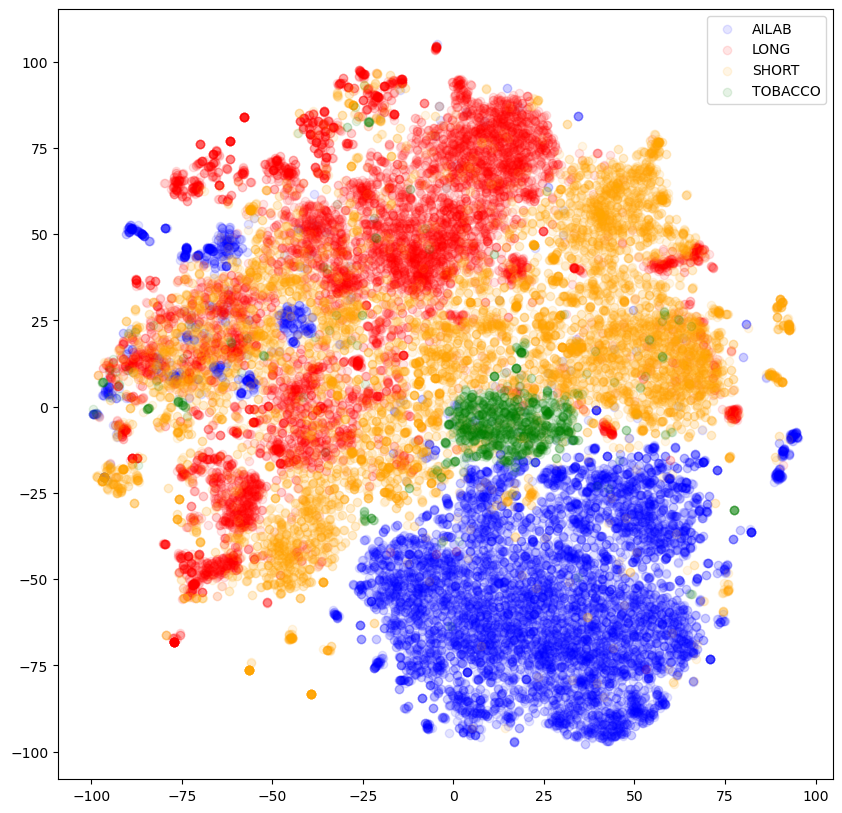

In [29]:
plot_tsne(tsne_features, alpha=0.1)

In the above Figure, we can see that the difference between C1, C2, Tobacco and the AI lab dataset is quite large, apart from some outliers. Although we are not quite sure where this difference comes from it might have to do with the markup of the documents. We can also see that altough there is some overlap between the C1 and C2 datasets, there is definitely a different between two two datasets, and they do not completely overlap. We can also see that the TOBACCO800 dataset overlaps with both the C1 and C2 datasets, and apparently shares many features with these two datasets. To investigate the differences between the visual representations of the datasets a bit more, we perform a simple cluster distance computation to evaluate both the distances between the clusters, as well as the within-cluster cohesion.

## Comparison between text vectors of LONG and SHORT

Because D1 and D2 are in the same language, we can compare the text vectors of LONG and SHORT to see how similar they actually are. To make things more clear, we will show the representations of the boundary pages, as this is the real interesting part, as these pages denote the difficulty in classification.

In [16]:
def get_dict_from_dataframe(dataframe):
    out = {}
    dataframe = dataframe.sort_values(['name', 'page'])
    for group_id, group in dataframe.groupby('name'):
        out[group_id] = group['label'].tolist()
    return out

In [28]:
tobacco = pd.concat([pd.read_csv('../vector_data/csv/tobacco/train.csv'), pd.read_csv('../vector_data/csv/tobacco/test.csv')])['label'].tolist()
ailab = pd.concat([pd.read_csv('../vector_data/csv/ailab/train.csv'), pd.read_csv('../vector_data/csv/ailab/test.csv')])['label'].tolist()


In [29]:
D1_gold_standard = {**read_json('../../ContextPSS/data/csv/D1/train_gold_standard.json'), **read_json('../../ContextPSS/data/csv/D1/test_gold_standard.json')}
D2_gold_standard = {**read_json('../../ContextPSS/data/csv/D2/train_gold_standard.json'), **read_json('../../ContextPSS/data/csv/D2/test_gold_standard.json')}
#tobacco_gold_standard = {**get_dict_from_dataframe(tobacco_train), **get_dict_from_dataframe(tobacco_test)}
#ailab_gold_standard = {**get_dict_from_dataframe(ailab_train), **get_dict_from_dataframe(ailab_test)}

In [30]:
D1_text_train_vectors = np.load('../vector_data/image_vectors/D1/train_vectors.npy', allow_pickle=True)[()]
D1_text_test_vectors = np.load('../vector_data/image_vectors/D1/test_vectors.npy', allow_pickle=True)[()]

In [31]:
D2_text_train_vectors = np.load('../vector_data/image_vectors/D2/train_vectors.npy', allow_pickle=True)[()]
D2_text_test_vectors = np.load('../vector_data/image_vectors/D2/test_vectors.npy', allow_pickle=True)[()]

In [32]:
tobacco_features = np.load('../../raw_images/TOBACCO800/features/vectors.npy')[np.nonzero(tobacco)[0]]
ailab_features = np.load('../../raw_images/AILAB/features/vectors.npy')[np.nonzero(ailab)[0]]

In [33]:
D1_text_vectors = {**D1_text_train_vectors, **D1_text_test_vectors}
D2_text_vectors = {**D2_text_train_vectors, **D2_text_test_vectors}

In [34]:
D1_start_pages = {key: value[np.array(D1_gold_standard[key]).nonzero(), :].squeeze() for key, value in D1_text_vectors.items()}
D2_start_pages = {key: value[np.array(D2_gold_standard[key]).nonzero(), :].squeeze() for key, value in D2_text_vectors.items()}

In [35]:
input_features = { 'LONG': np.vstack(list(D1_start_pages.values())),
                  'SHORT': np.vstack(list(D2_start_pages.values()))}
prepared_features, dataset_dict = prepare_images_for_visualization(input_features)
tsne_features = perform_tsne(prepared_features)

/Users/rvanheusden/anaconda3/envs/DutchRoberta/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [102]:
from PIL import Image
import io
from matplotlib.legend_handler import HandlerPathCollection

def plot_tsne(data, n_images = None, alpha: float=0.3):
    color_dict = {d:c for d, c in zip(list(dataset_dict.values()), ['blue', 'red', 'orange', 'green'])}
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    groups = np.split(data[:,:-1], np.unique(data[:, -1], return_index=True)[1][1:])
    hatches=['+', 'x']
    for i, group in enumerate(groups):
        ax.scatter(group[:, 0], group[:, 1], alpha=alpha, color=color_dict[dataset_dict[i]], label=dataset_dict[i],
                  edgecolor='black', hatch=hatches[i])

    leg = plt.legend(prop={'size': 12}, handlelength=4, handleheight=3)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh.set_sizes([200])

    plt.savefig('images/tsne_D1_D2.png')
    
    plt.show()

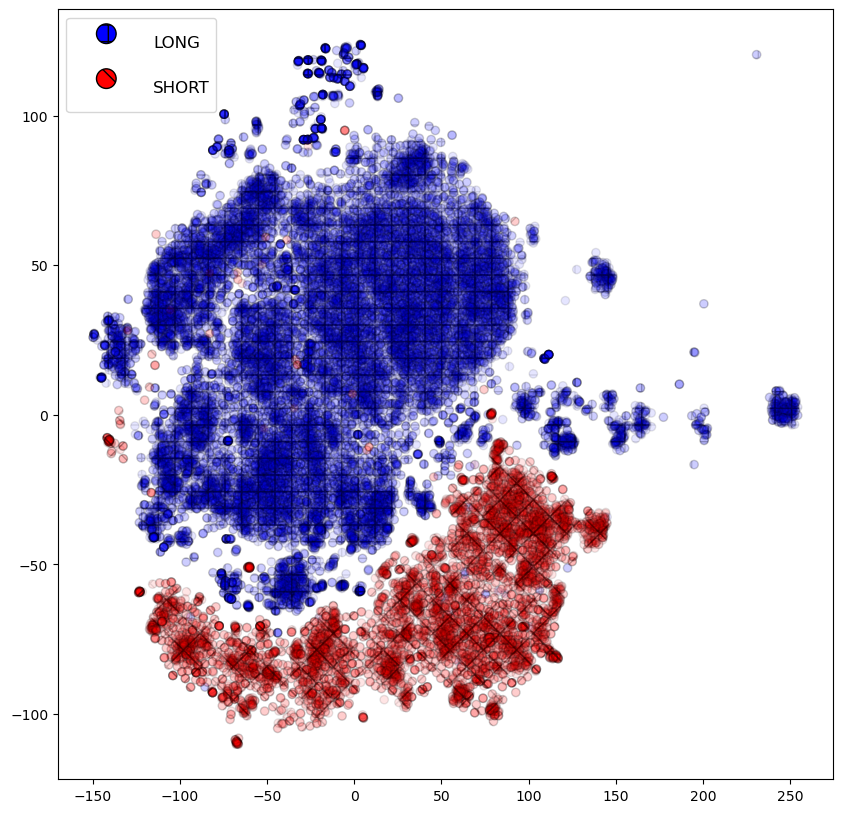

In [103]:
plot_tsne(tsne_features, alpha=0.1)
